<a href="https://colab.research.google.com/github/vieirafrancisco/machine-learning-ufal/blob/master/redes_neurais_artificiais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup

In [1]:
import os
from google.colab import drive
drive.mount('/drive')
os.chdir('/drive/My Drive/UFAL/machine-learning-ufal/video-game-sales')

Mounted at /drive


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [11]:
# dataset já pre-processado
df = pd.read_csv('data/fraud_dataset_pre_processed.csv', index_col=[0])

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0.00,0.000106,0.002855,0.003233,0.0,0.000000,0.0,0.0
1,0.00,0.000020,0.000357,0.000391,0.0,0.000000,0.0,0.0
2,0.25,0.000002,0.000003,0.000000,1.0,0.000000,0.0,1.0
3,0.50,0.000002,0.000003,0.000000,1.0,0.000059,0.0,1.0
4,0.00,0.000126,0.000697,0.000603,0.0,0.000000,0.0,0.0


In [15]:
print(f"Número total de tuplas: {len(df)}")
print(f"Número de tuplas com label isFraud == 1: {len(df[df['isFraud']==1])}")
print(f"Número de tuplas com label isFraud == 0: {len(df[df['isFraud']==0])}")

Número total de tuplas: 6362620
Número de tuplas com label isFraud == 1: 8213
Número de tuplas com label isFraud == 0: 6354407


# Análise preliminar e balanceamento

In [16]:
# verificar correlação entre os atributos antes de balancear
# com o objetivo de entender se tem algum atributo que influência bastante para a previsão da label
df.corr()

,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
type,1.000000,0.050693,0.415700,0.431006,0.808215,0.165383,0.135362,-0.004463
amount,0.050693,1.000000,-0.002762,-0.007861,0.197444,0.294137,0.459304,0.076688
oldbalanceOrg,0.415700,-0.002762,1.000000,0.998803,0.189486,0.066243,0.042029,0.010154
newbalanceOrig,0.431006,-0.007861,0.998803,1.000000,0.193915,0.067812,0.041837,-0.008148
nameDest,0.808215,0.197444,0.189486,0.193915,1.000000,0.231455,0.238315,0.025697
oldbalanceDest,0.165383,0.294137,0.066243,0.067812,0.231455,1.000000,0.976569,-0.005885
newbalanceDest,0.135362,0.459304,0.042029,0.041837,0.238315,0.976569,1.000000,0.000535
isFraud,-0.004463,0.076688,0.010154,-0.008148,0.025697,-0.005885,0.000535,1.000000


In [17]:
# curiosamente todos os atributos tem uma correlação proxima de 0 com relação a label
# por outro lado, alguns atributos entre si tem uma correlação muito alta, ex: new balanceOrig com oldbalanceOrg que de certa forma faz sentido
# melhorar a visualização dessa correlação e tentar remover alguns atributos, que tenham alta correlação entre si, para ver se interfere no resultado final

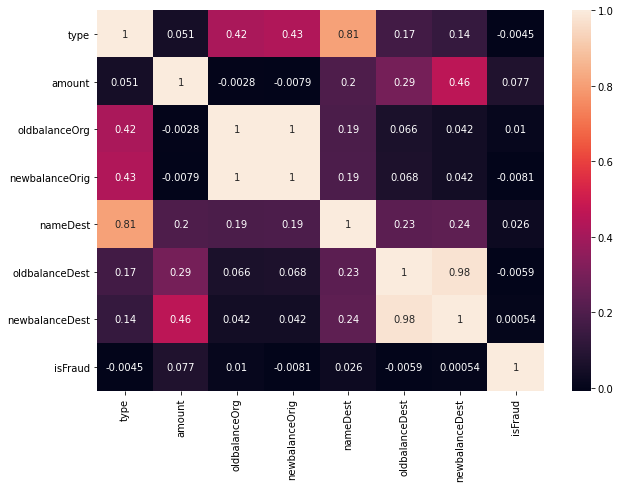

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.heatmap(df.corr(),annot=True, ax=ax)

## Balanceamento

In [33]:
df_balac = df[df['isFraud']==1]
# shuffle
shuffled = df[df['isFraud']==0].sample(frac=1)[:len(df_balac)]
# append
df_balac = df_balac.append(shuffled, ignore_index=True)

In [35]:
print(f"Número total de tuplas: {len(df_balac)}")
print(f"Número de tuplas com label isFraud == 1: {len(df_balac[df_balac['isFraud']==1])}")
print(f"Número de tuplas com label isFraud == 0: {len(df_balac[df_balac['isFraud']==0])}")

Número total de tuplas: 16426
Número de tuplas com label isFraud == 1: 8213
Número de tuplas com label isFraud == 0: 8213


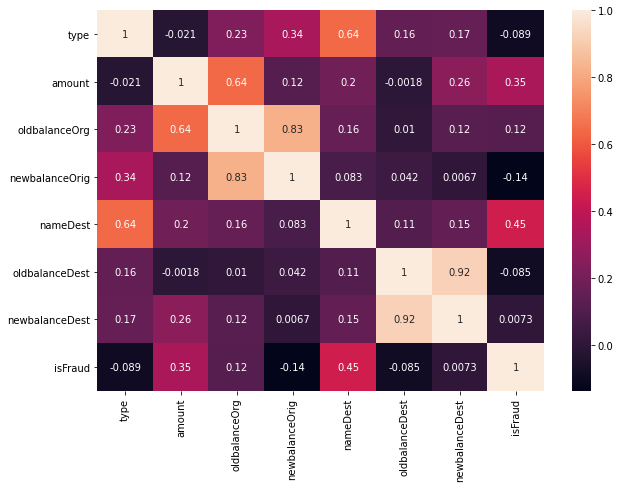

In [37]:
# verificar correlação com dataset balanceado
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.heatmap(df_balac.corr(),annot=True, ax=ax)

In [ ]:
# Com o balanceamento a correlação entre alguns atributos diminuiu levemente.
# Vou fazer a classificação com todos os atributos e depois vou fazer a classificação
# retirando alguns atributos que podem ser 'redundantes' no dataset

# Classificação com MLP

In [38]:
# imports
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold

In [43]:
# função de classificação
# retorna a accuracy, precision, recall
def classify(clf, X, y, cv=None):
    if cv is not None:
        method = f'{cv}-fold cross-validation'
        accuracy, precision, recall = cross_validation(clf, X, y, cv)
    else:
        method = f'holdout'
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        accuracy, precision, recall = hold_out(clf, X_train, X_test, y_train, y_test)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "method": method}
    

def hold_out(clf, X_train, X_test, y_train, y_test):
    # classificar
    clf.fit(X_train, y_train)
    # predição
    y_predict = clf.predict(X_test)

    # métricas
    acuracia = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    return (acuracia, precision, recall)

def cross_validation(clf, X, y, cv):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    metrics = {"accuracy": [], "precision": [], "recall": []}
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        accuracy, precision, recall = hold_out(clf, X_train, X_test, y_train, y_test)
        metrics["accuracy"].append(accuracy)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
    return (np.mean(metrics["accuracy"]), np.mean(metrics["precision"]), np.mean(metrics["recall"]))

In [40]:
y = df_balac['isFraud']
X = df_balac.drop('isFraud', axis=1)

In [41]:
X.head(2)

,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0.25,0.000002,0.000003,0.0,1.0,0.000000,0.0
1,0.50,0.000002,0.000003,0.0,1.0,0.000059,0.0


In [54]:
# Holdout
result_df = pd.DataFrame(classify(MLPClassifier(), X, y), index=[0])

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [57]:
# Cross-validation 10 folds
k_fold = pd.DataFrame(classify(MLPClassifier(), X, y, cv=10), index=[1])

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [58]:
result_df = result_df.append(k_fold, ignore_index=True)

In [59]:
result_df

,accuracy,precision,recall,method
0,0.936093,0.943337,0.927173,holdout
1,0.944538,0.952880,0.935179,10-fold cross-validation


In [ ]:
# remover alguns atributos que tem alta com relação com outro atributo para verificar o resultado de classificação
df_balac_withoud_old_balance = df_balac.drop(['oldbalanceDest', 'oldbalanceOrg'], axis=1)
holdout = classify(MLPClassifier(), X, y)
cv_10_fold = classify(MLPClassifier(), X, y, cv=10)

In [64]:
result_df = pd.DataFrame(holdout, index=[0])
cv_10_fold_df = pd.DataFrame(cv_10_fold, index=[1])
result_df = result_df.append(cv_10_fold_df, ignore_index=True)

In [65]:
result_df

,accuracy,precision,recall,method
0,0.952222,0.954299,0.951439,holdout
1,0.947096,0.947437,0.946658,10-fold cross-validation


# Conclusão
Em geral os resultados utilizando o classificador da MLP (com os parâmetros padrão) teve um resultado bom, porém inferior tanto das Árvores de Decisão como também das Random Forest. Removendo dois atributos 'oldbalanceDest' e 'oldbalanceOrg' as métricas tem uma leve melhoria no método holdout nas três metricas utilizadas: accuracy, precision e recall

In [67]:
# salvar dataset balanceado
df_balac.to_csv('data/fraud_dataset_ready_to_use.csv')